# Information diffusion on networks

<div style="display: flex; align-items: center;">
    <a target="_blank" href="https://colab.research.google.com/github/yy/netsci-course/blob/master/docs/m10-infodiff/lab10.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" style="vertical-align: -8px; margin-right: 10px;" />
        Open this notebook in Google Colab
    </a>
</div>


<div style="display: flex; align-items: center;">
    <a href="https://raw.githubusercontent.com/yy/netsci-course/master/docs/m10-infodiff/lab10.ipynb" download>
        <img src="http://yyahn.com/netsci-course/images/download_icon.png" style="vertical-align: -8px; margin-right: 10px;" />
        Download this notebook (File -> Save As)
    </a>
</div>

Information diffusion or social contagion refers to all kinds of social phenomena where information, ideas, rumors, behaviors, beliefs, etc. spread through a network of people. This process is crucial in understanding our society. If you think about it, most social phenomena can be thought of as information diffusion processes and many challenges that our society is facing is often less about the lack of technology or resources but more about the challenge of effective information diffusion.

Politics? It's about spreading a coherent set of ideas and beliefs about how our society should be run. Climate change? The biggest challenge is to convince people that it's real and urgent, so that the society can act on it. Fake news and influence campaigns? It's about spreading misinformation and manipulating people's beliefs and behaviors. 

So, how do we model and study information diffusion and what can network science help us understand about it? 


## Models of information diffusion

Because of an obvious similarity and parallel between the spread of information and the spread of diseases, many (early) models of information diffusion are inspired by epidemic models. Many studies on information diffusion these days do use epidemic models. When we do that, we can bring all the knowledge, models, and techniques developed in the field of epidemiology. 

Another simple model that was inspired by these epidemic model is the **Independent Cascade Model**. In this model, we assume a set of seed nodes that are initially "infected" (or active), whereas all other nodes are "susceptible" or inactive. In each time step, a newly activated node can activate its neighbors with a certain probability. Each activated node has only one chance to activate its neighbors and if a node has multiple activated neighbors, _each of these neighbors can "try" to activate the node independently_. In other words, if a node has three newly activated neighbors, the probability that it will be activated is not simply $p$, but $1 - (1 - p)^3$.

Thanks to its simplicity, this model is widely used in the study of information diffusion, particularly for the problem of influence maximization (choosing the best seeds to maximize the spread of information).

But, as you have read, there are also many pieces of evidence that suggest that information diffusion is not like disease spreading because one's adoption of a behavior or belief is often strongly modulated by social signals. As more and more people around you adopt a behavior, you are more likely to adopt it. This is called _social reinforcement_ and it can produce a very different pattern of information diffusion compared to the epidemic models or the independent cascade model. 

## Independent cascade model

Let's try the independent cascade model first. Let's simplify the model by assumping a fixed probability $p$ that a node will activate its neighbor. Let's first create a small network to play with. 

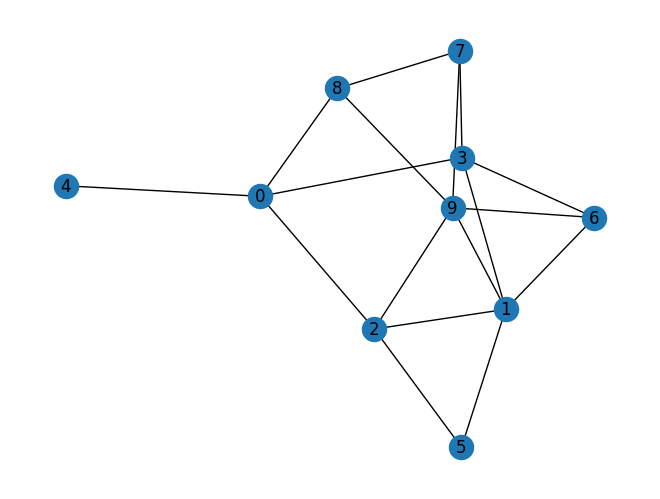

In [2]:
import networkx as nx
import numpy as np

G = nx.erdos_renyi_graph(10, 0.3, seed=42)
nx.draw(G, with_labels=True)

We will need to keep track of newly activated nodes, and then in each step, we need to 'try' all of their neighbors for the activation. So we need to be able to obtain the target nodes. 

In [3]:
newly_activated = {0, 5}

def get_target_nodes(G, newly_activated):
    target_nodes = set()
    for node in newly_activated:
        for neighbor in G.neighbors(node):
            target_nodes.add(neighbor)
    return target_nodes

print(list(G.neighbors(0)))
print(list(G.neighbors(5)))
print(get_target_nodes(G, newly_activated))

[2, 3, 4, 8]
[1, 2]
{1, 2, 3, 4, 8}


Is this correct? 🤨 Please take a look at the code closely and see if there is any problem.

**Q: Given the definition of independent cascade model, what is wrong with this code? Please fix it.**

In [4]:
def get_target_nodes(G, newly_activated):
    # YOUR SOLUTION HERE
    return target_nodes

# print(get_target_nodes(G, newly_activated))    # show the correct output (target nodes). 

Now we can implement the independent cascade model. 

In [36]:
def indep_cascade(G: nx.Graph, seeds: set, p: float = 0.1):
    """ Independent cascade model. 
    
    returns a list that contains newly activated nodes at each time step.

    """
    
    activated = seeds.copy()
    newly_activated = seeds.copy()
    result = [newly_activated.copy()]

    # YOUR SOLUTION HERE
    
    return result


In [37]:
indep_cascade(G, {0, 5}, 0.4)

[{0, 5}, {2, 3, 4}, {1, 7, 9}, {6}, set()]

Let's visualize this. Because the network is small and we only have a few steps, we can visualize the network at each step.

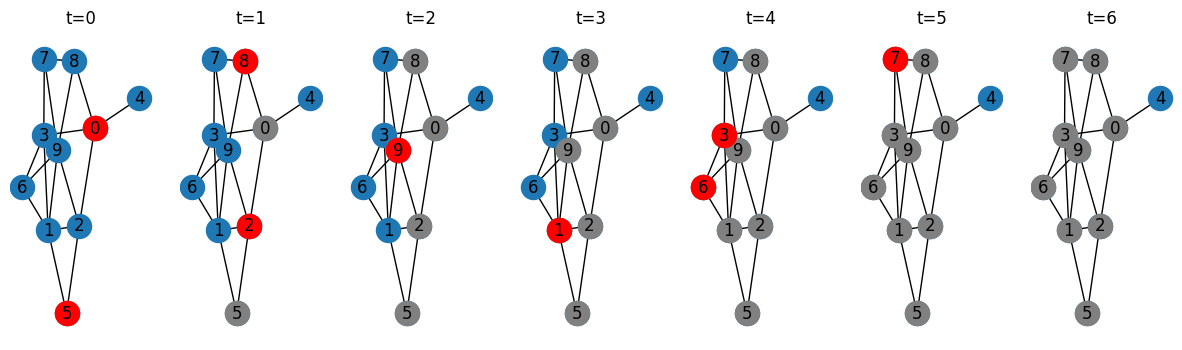

In [77]:
# visualize the result of indep_cascade. 
import matplotlib.pyplot as plt

G = nx.erdos_renyi_graph(10, 0.3, seed=42)
layout = nx.spring_layout(G)

result = indep_cascade(G, {0, 5}, 0.4)

# create a subplot based on the number of time steps in result
fig, axes = plt.subplots(1, len(result), figsize=(15, 4))

activated = set()
for i, newly_activated in enumerate(result):
    activated |= newly_activated
    ax = axes[i]
    nx.draw(G, pos=layout, with_labels=True, ax=ax)
    nx.draw_networkx_nodes(G, pos=layout, nodelist=activated, node_color='grey', ax=ax)
    nx.draw_networkx_nodes(G, pos=layout, nodelist=newly_activated, node_color='r', ax=ax)
    ax.set_title(f't={i}')

plt.show()


## Threshold model

Now let's implement the threshold model, which captures the social reinforcement mechanism. Imagine a situation with peer pressure. For instance, if everyone in your circle of friends is adopting a new gadget, social media, new sports, or anything, each additional adoption by your friends makes you more likely to adopt it. This is exactly what exactly the threshold model captures. 

In the threshold model, each node has a threshold $T_i$. When the fraction of activated neighbors exceeds the threshold, the node will be activated. Also, once activated, the node will stay activated. For simplicity, we will assume a fixed threshold for all nodes.

Let's start with the same network. 

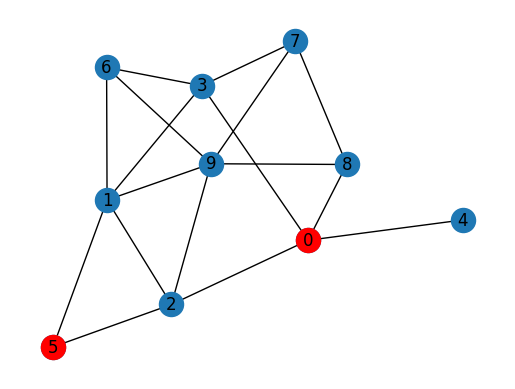

In [78]:
activated = {0, 5}

layout = nx.spring_layout(G)
fig, ax = plt.subplots()
nx.draw(G, pos=layout, with_labels=True, ax=ax)
nx.draw_networkx_nodes(G, pos=layout, nodelist=activated, node_color='r', ax=ax)

The only possible nodes that can be activated are the ones that are connected to the activated nodes. So let's first find the set of nodes that we need to look at. 

In [79]:
neighbors_of_activated = set()
for node in activated:
    neighbors_of_activated |= set(G.neighbors(node))

candidates = neighbors_of_activated - activated
candidates

{1, 2, 3, 4, 8}

For each of these nodes, we need to check if the fraction of activated neighbors exceeds the threshold. To do so, let's first define a simple threshold function. 

In [80]:
threshold = 0.4

def should_be_activated(G, node, activated, threshold):
    # YOUR SOLUTION HERE

for node in candidates:
    print(node, should_be_activated(G, node, activated, threshold))

1 False
2 True
3 False
4 True
8 False


Now we are ready to run the threshold model. 

In [81]:
def threshold_model(G, seeds, threshold):
    result = [seeds.copy()]
    activated = seeds.copy()

    # YOUR SOLUTION HERE

    return result

In [82]:
threshold_model(G, {0, 5}, 0.4)

[{0, 5}, {2, 4}, {1}, {3, 9}, {6, 7, 8}]

Let's visualize this. 

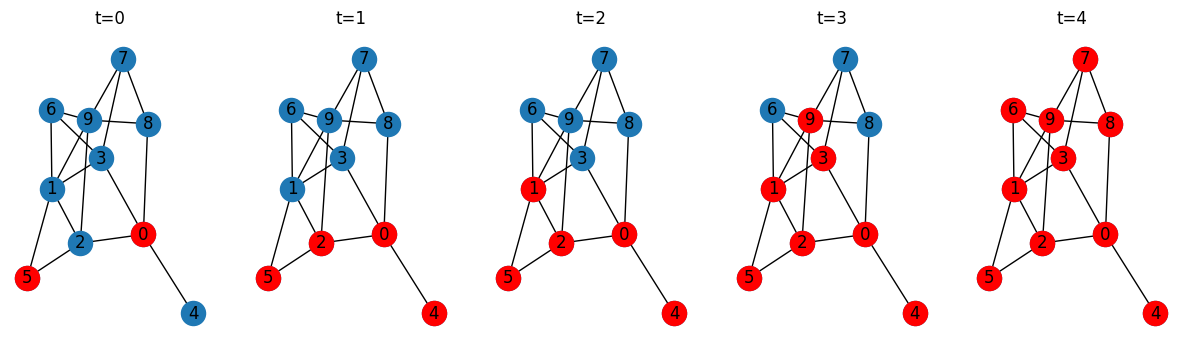

In [122]:
def visualize_contagion(G, result, g_kwargs={"with_labels": True}, node_kwargs={}):
    # YOUR SOLUTION HERE

visualize_contagion(G, threshold_model(G, {0, 5}, 0.4))

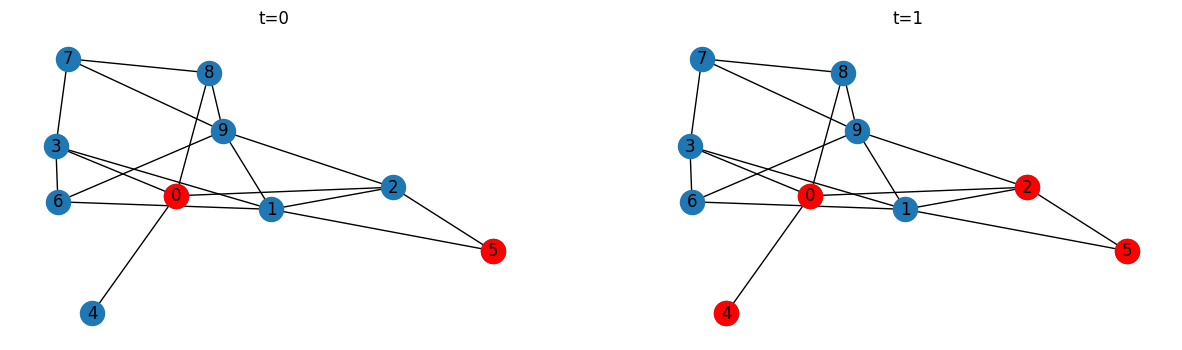

In [123]:
visualize_contagion(G, threshold_model(G, {0, 5}, 0.5))

Now, can you run these two models on the Watts-Strogatz networks?  

**Q: play with model parameters and discuss the result. How does the contagion's behavior change as you vary the parameters? For instance, how well the threshold model spread as you change the randomization parameter of the Watts-Strogatz model?**

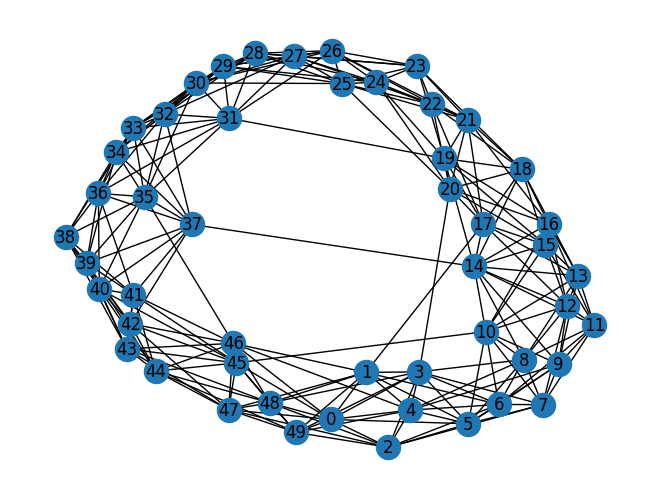

In [161]:
G_ws = nx.watts_strogatz_graph(50, 10, 0.05, seed=42)   # Try different paramters. 
nx.draw(G_ws, with_labels=True)

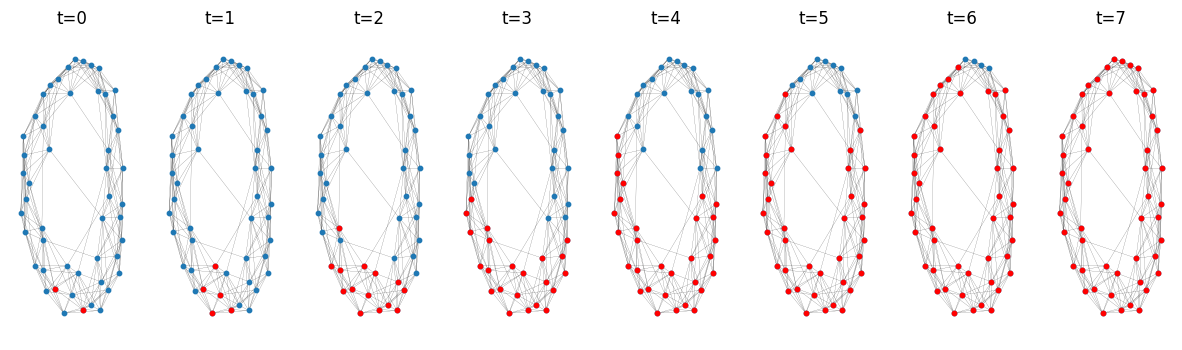

In [162]:
visualize_contagion(G_ws, threshold_model(G_ws, {0, 5}, 0.2), 
                    g_kwargs={"with_labels": False, "node_size": 10, "width": 0.1}, node_kwargs={"node_size": 10})

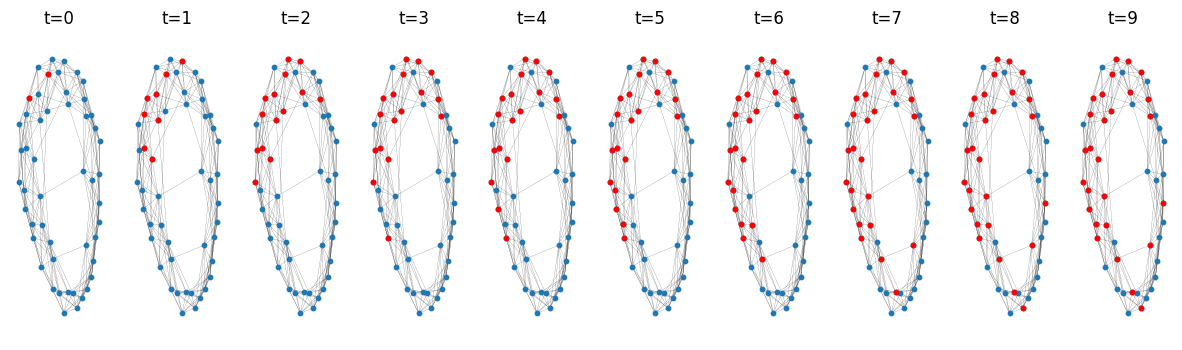

In [163]:
visualize_contagion(G_ws, indep_cascade(G_ws, {0, 5}, 0.15), 
                    g_kwargs={"with_labels": False, "node_size": 10, "width": 0.1}, node_kwargs={"node_size": 10})

<pre>
# YOUR SOLUTION HERE
</pre>